In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

#X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
#Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

X_motion_CoM = X_motion_CoM_acceleration
Y_motion_CoM = Y_motion_CoM_acceleration

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(5387, 27)
(5387, 3)


In [6]:
X_motion_CoM[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.22854666411876678,
       0.12870857119560242, -0.3830883204936981, 0.24612823128700256,
       -0.12833303213119507, -0.37785547971725464, -0.2489081770181656,
       0.12461630254983902, -0.38896113634109497, -0.269717276096344,
       -0.12609580159187317, -0.38343119621276855, 0.09078800678253174,
       -0.037348683923482895, 0.02203107438981533, 0.06813523918390274,
       0.04039946989656461, -0.01379605675012701, -0.02830420089540658,
       True, False], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(2698,)

In [10]:
X_motion_CoM_FL_RR[0, :]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.22854666411876678,
       0.12870857119560242, -0.3830883204936981, 0.24612823128700256,
       -0.12833303213119507, -0.37785547971725464, -0.2489081770181656,
       0.12461630254983902, -0.38896113634109497, -0.269717276096344,
       -0.12609580159187317, -0.38343119621276855, 0.09078800678253174,
       -0.037348683923482895, 0.02203107438981533, 0.06813523918390274,
       0.04039946989656461, -0.01379605675012701, -0.02830420089540658,
       True, False], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.02672861137026078, 0.0011061801215013073, 0.0006479850081065885],
      dtype=object)

## Predict CoM -> x

### Linear Regression

In [22]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))0.04954298

R2:  0.9725668716842126
RMSE:  0.012232142886140553
The lowest error is:  4.965582641763833e-06
The highest error is:  0.042613947296236604
The avg. error is:  0.009351503170642412


In [23]:
model_fl_com_x.coef_

array([[ 7.24552341e-03,  2.49800181e-16,  1.76941795e-16,
         6.41195343e-02,  5.55111512e-17, -2.63677968e-16,
         2.27727958e-01,  2.11152332e-01, -9.54239812e-02,
         2.09440299e-03,  1.49950923e-01, -6.50530451e-01,
        -3.87961824e-01,  6.57983614e-01,  2.10521581e-01,
         5.67005503e-01, -2.26922012e-01,  4.26763477e-01]])

In [24]:
model_fl_com_x.intercept_

array([0.21400358])

In [25]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 18 is different from 14)

Text(0, 0.5, 'Predictions')

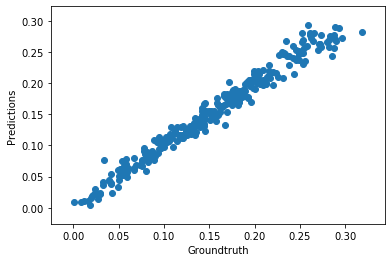

In [26]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [27]:
#%store model_fl_com_x

In [28]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [30]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.6347905769147362
RMSE:  0.003332706148989522
The lowest error is:  2.208091741222329e-05
The highest error is:  0.010125449949273009
The avg. error is:  0.0026673919026526344


In [31]:
model_fl_com_y.coef_

array([[-3.27346856e-03,  1.26634814e-16,  7.97972799e-17,
        -4.41215809e-03,  1.56125113e-17,  4.16333634e-17,
         4.74372504e-02,  2.72256278e-02, -4.95738171e-03,
        -1.59052453e-03,  1.05211971e-01, -4.17793035e-01,
        -5.32452419e-02,  2.30569673e-01, -1.19047986e-01,
         1.36511055e-01, -9.09861445e-02, -1.72150833e-01]])

In [32]:
model_fl_com_y.intercept_

array([-0.02391585])

Text(0, 0.5, 'Predictions')

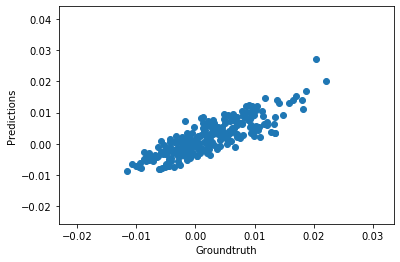

In [33]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [28]:
#%store model_fl_com_y

In [29]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [53]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [36]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.46368859401483775
RMSE:  0.0023957678723095957
The lowest error is:  1.0373183757475535e-05
The highest error is:  0.006940630941991946
The avg. error is:  0.001946520389359923


In [37]:
model_fl_com_theta.coef_

array([[ 1.50704664e-03, -1.21430643e-17, -1.64798730e-17,
         6.99620378e-04, -2.08166817e-17, -3.46944695e-17,
        -8.87330895e-03, -1.65762421e-02,  7.51065314e-03,
        -7.87796758e-03, -4.39059199e-02, -1.73056479e-02,
         1.36747489e-02, -2.48819752e-02,  5.26059308e-02,
        -1.77695465e-01,  1.23857129e-01,  8.83107424e-02]])

In [38]:
model_fl_com_theta.intercept_

array([0.08482643])

Text(0, 0.5, 'Predictions')

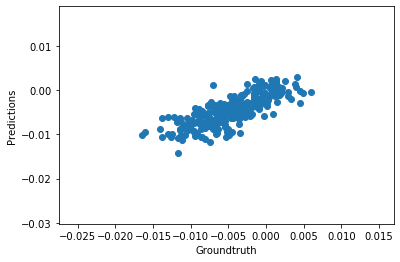

In [33]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")